
## About this project

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from selenium import webdriver
import pandas as pd
import time
import random
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))
from inmoclick_clean_utils import (fix_clean_total_area,
                                  fix_clean_floor_area,
                                  str_serie_to_vector,
                                  vectors_sparse_similarity,
                                  are_similar_properties)

# 1.0- Loading Data

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
houses = pd.read_csv("dataframe_house.csv")
apartments = pd.read_csv("dataframe_apartment.csv")
lands = pd.read_csv("dataframe_land.csv")

In [4]:
fil = houses[houses.district=="Lujan de Cuyo"]
fil = fil[fil.bedrooms=='3']
fil = fil[fil.totalArea=='disable']
fil = fil[fil.bathrooms=='2']
fil.url[:3].values

array(['/52708-remax-chacras/inmuebles/564/ficha/casa-en-venta-en-los-peralitos?btid=3419445',
       '/52708-remax-chacras/inmuebles/574/ficha/casa-en-venta-en-barrio-parque-drummond?btid=3419445',
       '/17515-remax-solutions/inmuebles/1805/ficha/casa-en-venta-en-gobernador-ortiz?btid=3419445'],
      dtype=object)

## 2- Getting duplicated houses

### 2.1- Cleaning and filtering data

In [5]:
print(f'Quantity before cleaning: {len(apartments)}')
apartments = fix_clean_total_area(apartments)
apartments = fix_clean_floor_area(apartments)
print(f'Quantity after cleaning: {len(apartments)}')

Quantity before cleaning: 2304
Quantity after cleaning: 2087


### 2.2- Looking for similar neighborhoods

In [7]:
vectorized_neighborhoods = str_serie_to_vector(apartments.neighborhood)
neighborhoods_similarity = vectors_sparse_similarity(vectorized_neighborhoods, vectorized_neighborhoods)

similarity_threshold =  0.8
idx,jdx = np.where(neighborhoods_similarity >= similarity_threshold)
total_comparisons = neighborhoods_similarity.shape[0]*neighborhoods_similarity.shape[1]
print(f'Positive neighborhoods comparisons(similarity upper to {similarity_threshold}): {len(idx)} of {total_comparisons}')

Positive neighborhoods comparisons(similarity upper to 0.8): 4591 of 4355569


### 2.3- Looking for similar properties

In [13]:
similar_apartments = []    
for i,j in zip(idx,jdx):
    iprop = apartments.iloc[i]
    jprop = apartments.iloc[j]
    if i!=j and are_similar_properties(iprop,jprop):
        similar_apartments.append([iprop.ref_id,iprop.url,jprop.ref_id,jprop.url,neighborhoods_similarity[i,j]])
similar_apartments_df = pd.DataFrame(similar_apartments,columns=['ref_id1','url1','ref_id2','url2','cosine_sim'])

# Creating a single list with posible duplicateds
apartments_with_similarities = pd.concat([similar_apartments_df.ref_id1, similar_apartments_df.ref_id2]).unique()
print(f'Quantity of apartments with similarities: {len(apartments_with_similarities)}')

similar_apartments_df.head(3)

Quantity of apartments with similarities: 211


,ref_id1,url1,ref_id2,url2,cosine_sim
0,inmueble-11248-1905,/11248-openhouse-negocios-inmobiliarios/inmueb...,inmueble-2504-110,/2504-cefas-inmobiliaria/inmuebles/110/ficha/d...,1.0
1,inmueble-11248-1905,/11248-openhouse-negocios-inmobiliarios/inmueb...,inmueble-2504-42,/2504-cefas-inmobiliaria/inmuebles/42/ficha/de...,1.0
2,inmueble-11248-1905,/11248-openhouse-negocios-inmobiliarios/inmueb...,inmueble-2504-43,/2504-cefas-inmobiliaria/inmuebles/43/ficha/de...,1.0


### 2.4*- Showing the greatest similarity quantities

In [15]:
top_similiarities = similar_apartments_df.groupby(['ref_id1']).count().ref_id2.to_frame().reset_index()
top_similiarities.columns = ['ref_id','duplicated_qty']
top_similiarities = top_similiarities.sort_values("duplicated_qty",ascending=False)
top_similiarities.head(3)

,ref_id,duplicated_qty
82,inmueble-2504-110,6
88,inmueble-2504-42,6
40,inmueble-11737-51,5


## 3.0- Analyzing agencies with duplicateds houses

### 3.1- Adding a mark "is_duplicated" to the properties

In [16]:
simil_df = pd.DataFrame(apartments_with_similarities,columns=['ref_id'])
simil_df['is_duplicated'] = 1
# extended_apartments
ext_apartments = apartments.merge(simil_df, left_on='ref_id', right_on='ref_id',how='left')
ext_apartments.head(2)

,ref_id,neighborhood,district,province,price,currency,amount,url,description,totalArea,bedrooms,bathrooms,floorArea,agency,property_type,source_web,scrapped_date,totalArea_fixed,floorArea_fixed,is_duplicated
0,inmueble-438-2913,F Moyano 1525 Quinta Sección Edificio H,Capital,Mendoza,US$ 180.000,US$,180000.0,/438-de-lucia/inmuebles/2913/ficha/departament...,Inmobiliaria De Lucia vende Departamento en co...,140,2,2.0,83,De Lucia,PropertyType.APARTMENT,inmoclick,2020-07-18,140.0,83.0,NaN
1,inmueble-11737-62,PASO,Maipu,Mendoza,US$ 47.000,US$,47000.0,/11737-las-marias-desarrollos-inmobiliarios/in...,"SOS INVERSOR Y BUSCÁS UN DESARROLLO EN MAIPÚ, ...",85,2,1.0,75,Inmobiliaria,PropertyType.APARTMENT,inmoclick,2020-07-18,85.0,75.0,NaN


### 3.2- Showing top agencies with duplicated properties

Agencies:62
Duplicated properties:211


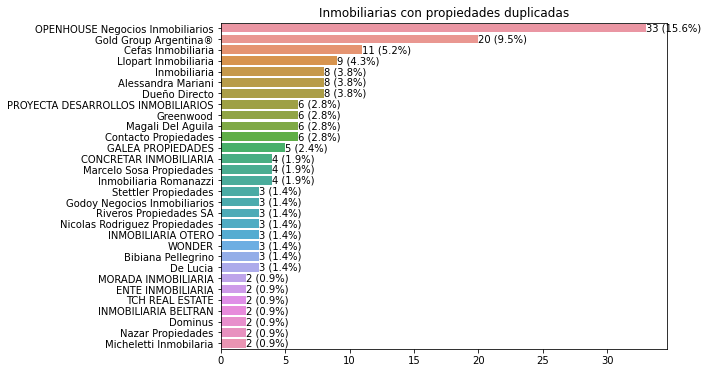

In [17]:
agency = ext_apartments[ext_apartments.is_duplicated==1].groupby("agency").count().ref_id.sort_values(ascending= False)
share = round(agency/agency.sum()*100,1)
print("Agencies:"+str(len(agency)))
print("Duplicated properties:"+str(len(ext_apartments[ext_apartments.is_duplicated==1])))

agency = agency.head(30)
plt.figure(figsize=(8,6))
g = sns.barplot(x=agency.values, y=agency.index.values)

for i,row in enumerate(agency.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Inmobiliarias con propiedades duplicadas')
plt.show()